In [66]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit

# General functions

In [67]:
dataset

,ice_extent,mean_temp
date,,
1979-02-01,0.761286,-3.1
1979-03-01,0.166652,12.4
1979-04-01,-0.895138,3.7
1979-05-01,-1.589933,6.1
1979-06-01,-1.326867,5.8
...,...,...
2018-03-01,0.330331,5.0
2018-04-01,-0.601514,-2.0
2018-05-01,-1.464034,18.0


In [92]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation from column: ' + title)
    plt.show(block=False)
    
def full_graph(predicted_diff, title):
    dataset_ie = ts[['ice_extent']][:-5]
    predictionsArray = np.asarray(revert_diff(predicted_diff, dataset_ie))
    zerosArray = np.zeros(dataset_ie.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(dataset_ie.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 2 year prediction')
    plt.ylim([0,20])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

# Dataprep

In [69]:
ts = pd.read_csv('./data/dataframe_monthly.csv', index_col=0).reset_index()

In [70]:
ts

,Year,Month,mean_temp,ice_extent
0,1979,1,-7.700000,15.414000
1,1979,2,-10.800000,16.175286
2,1979,3,1.600000,16.341938
3,1979,4,5.300000,15.446800
4,1979,5,11.400000,13.856867
...,...,...,...,...
475,2018,8,24.000000,5.614806
476,2018,9,21.000000,4.785233
477,2018,10,10.000000,6.134097
478,2018,11,6.000000,9.823133


In [71]:
ts['date'] = pd.to_datetime(ts['Month'].astype(str) + ts['Year'].astype(str), format='%m%Y', errors='ignore')

In [72]:
ts

,Year,Month,mean_temp,ice_extent,date
0,1979,1,-7.700000,15.414000,1979-01-01
1,1979,2,-10.800000,16.175286,1979-02-01
2,1979,3,1.600000,16.341938,1979-03-01
3,1979,4,5.300000,15.446800,1979-04-01
4,1979,5,11.400000,13.856867,1979-05-01
...,...,...,...,...,...
475,2018,8,24.000000,5.614806,2018-08-01
476,2018,9,21.000000,4.785233,2018-09-01
477,2018,10,10.000000,6.134097,2018-10-01
478,2018,11,6.000000,9.823133,2018-11-01


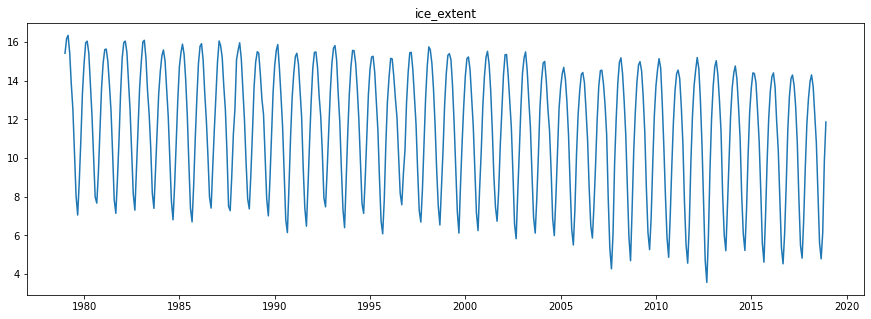

Text(0.5, 1.0, 'mean_temp')

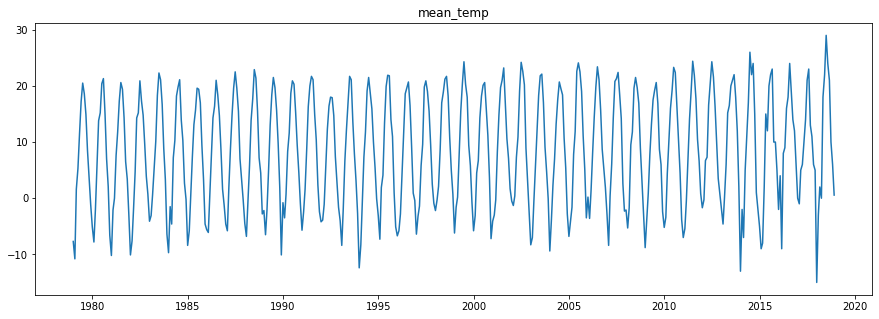

In [73]:
ts = ts[['date','ice_extent','mean_temp']]
ts.set_index('date', inplace=True)
plt.plot(ts[['ice_extent']])
plt.title('ice_extent')
plt.show()
plt.plot(ts[['mean_temp']])
plt.title('mean_temp')


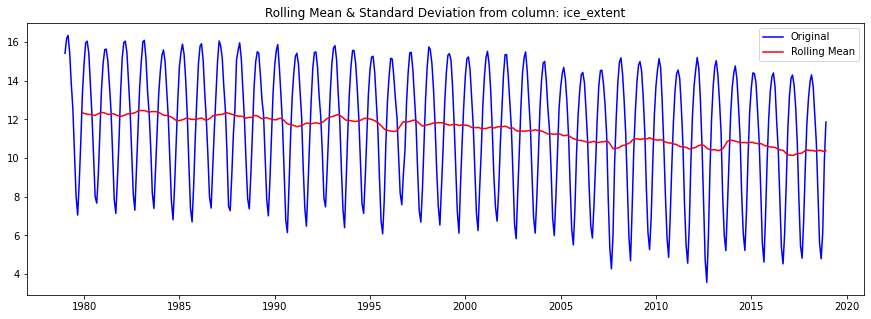

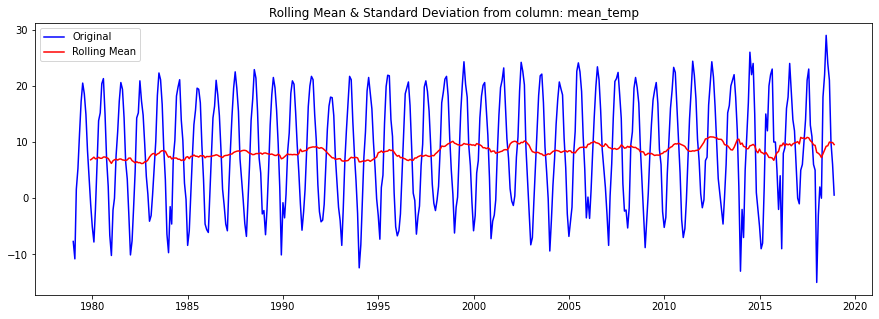

In [74]:
test_stationarity(ts[['ice_extent']], 'ice_extent')
test_stationarity(ts[['mean_temp']], 'mean_temp')

# Differencing

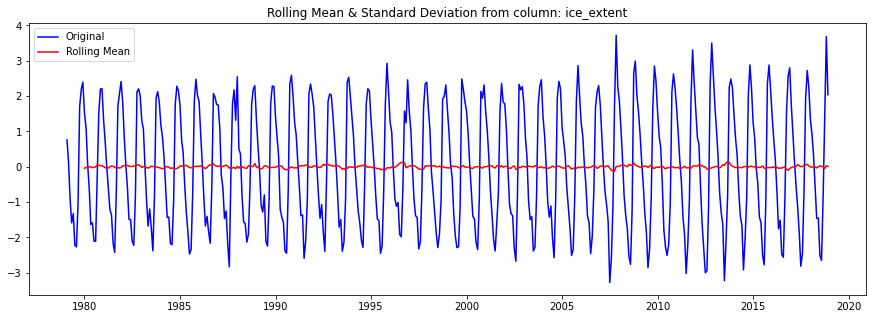

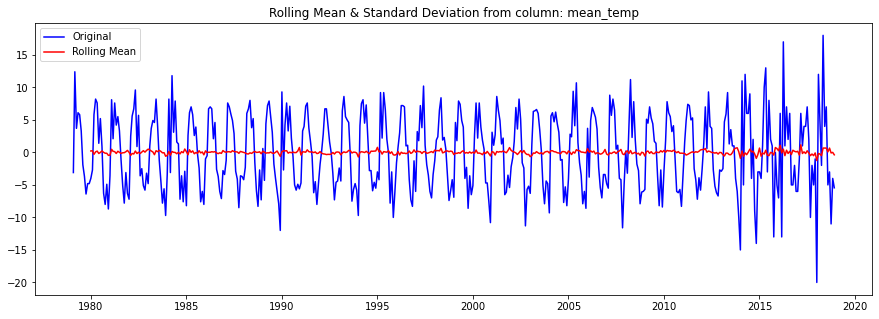

In [75]:
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff[['ice_extent']], 'ice_extent')
test_stationarity(ts_diff[['mean_temp']], 'mean_temp')

In [76]:
tscv = TimeSeriesSplit(n_splits = 18)
dataset = ts_diff[:-5] # need the -5 to get testsets for 24 months/2 years

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 306
TEST: 24

TRAIN: 330
TEST: 24

TRAIN: 354
TEST: 24

TRAIN: 378
TEST: 24

TRAIN: 402
TEST: 24

TRAIN: 426
TEST: 24

TRAIN: 450
TEST: 24



## VARMAX

In [195]:
%%time
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))
best_pq = pq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 300:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = VARMAX(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.forecast(steps=24, dynamic=False)
                prediction_values = predictions[['ice_extent']].values
                true_values = cv_test[['ice_extent']].values
                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pq)

# best range(0,5)
# Best MAE = 0.1772618201196872
# (1, 1)
# Wall time: 7min 53s


(0, 0)
Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
(0, 1)
MAE: 1.5873814745059553
(0, 2)
MAE: 1.561872097711858
(0, 3)


KeyboardInterrupt: 

In [ ]:
best_pq = (1,1)

-------
IIIIIII
Mean MAE: 0.622 x 1 000 000 km²
MAE of last prediction: 0.667 x 1 000 000 km²
Execution time: 124.636 seconds


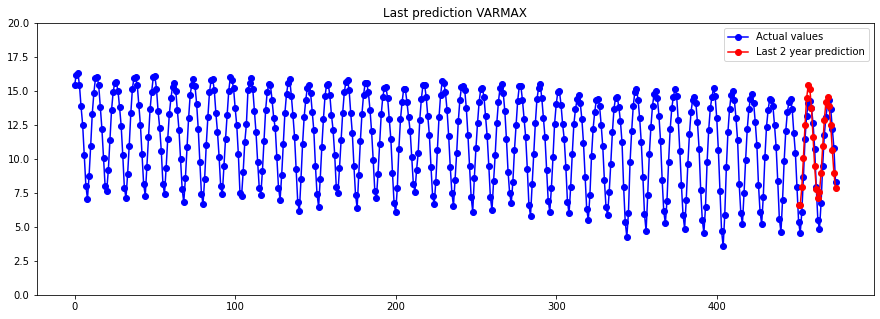

In [94]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("-------")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = VARMAX(cv_train, order=(best_pq))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.forecast(steps=24, dynamic=False)
        prediction_values = predictions[['ice_extent']].values
        true_values = cv_test[['ice_extent']].values
        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    

time_VARMAX = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_VARMAX = mae_mean
last_MAE_VARMAX = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_VARMAX)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_VARMAX)
print('Execution time: %.3f seconds' % time_VARMAX)
full_graph(prediction_values, 'Last prediction VARMAX')

# SARIMAX

In [171]:
# setting up values for displaying prediction of the last 2 years
data = dataset
test_size = 24
data_train = data[:-test_size]
data_test = data[-test_size:]

1.4311424980477554


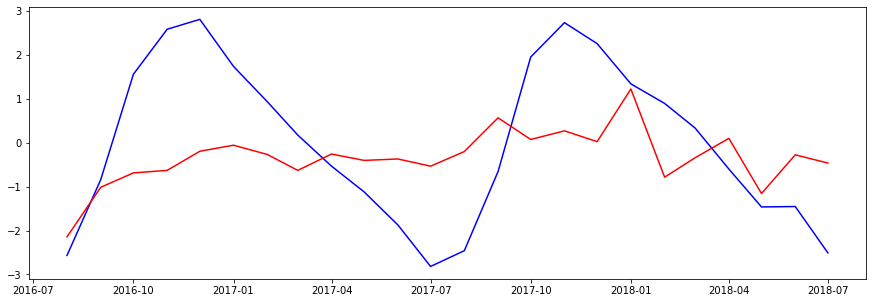

Wall time: 397 ms


In [194]:
%%time
# singular test

import itertools
import warnings
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Variables
endog = data_train[['ice_extent']]
exog = sm.add_constant(data_train[['mean_temp']])
exog_test = sm.add_constant(data_test[['mean_temp']])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog)

# fit model
model_fit = model.fit()

yhat = model_fit.forecast(steps = 24, exog=exog_test)

mae = mean_absolute_error(yhat, data_test[['ice_extent']])

# plot
print(mae)
plt.plot(data_test[['ice_extent']], color='blue')
plt.plot(yhat, color='red')
plt.show()

Adding exogenous variables with SARIMAX requires to give the mean temperatures from the testset for forecasting, which is not in line with the other usecases, therefore it won't be further explored
(extra research!)

# LSTM

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [24]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.142027,0.793825,0.358361,0.990989,0.186121,0.809512,0.449184,0.890624
2,0.186121,0.809512,0.449184,0.890624,0.341349,0.646414,0.791294,0.956703
3,0.341349,0.646414,0.791294,0.956703,0.606695,0.629914,0.386484,0.960365
4,0.606695,0.629914,0.386484,0.960365,0.700030,0.644422,0.276378,0.967109
5,0.700030,0.644422,0.276378,0.967109,0.817765,0.795618,0.202454,0.969972
...,...,...,...,...,...,...,...,...
127,0.929222,0.606574,0.187907,0.964551,0.902454,0.552789,0.229572,0.969770
128,0.902454,0.552789,0.229572,0.969770,0.783331,0.604183,0.000000,0.970348
129,0.783331,0.604183,0.000000,0.970348,0.543362,0.714144,0.581003,0.975306
130,0.543362,0.714144,0.581003,0.975306,0.371445,0.928386,0.411313,0.972924


In [25]:
values[0]

array([-2.5498209e+00,  8.7741935e-01,  8.4904127e+00,  1.0281178e+03],
      dtype=float32)

In [26]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
# print(reframed.head())

In [27]:
# split into train and test sets
values = reframed.values
n_train_days = 100
# n_test_days = values.shape[0] - 3000

train = values[:n_train_days, :]
test = values[n_train_days:]

In [28]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [29]:
test_X

array([[0.7087678 , 0.6444223 , 0.37037462, 0.9592583 ],
       [0.82154906, 0.39628148, 0.27917463, 0.9637883 ],
       [0.90537274, 0.69721127, 0.29271668, 0.95827603],
       [0.86969686, 0.69920325, 0.2274571 , 0.9612262 ],
       [0.7771561 , 0.8378155 , 0.2748047 , 0.9665215 ],
       [0.6330502 , 0.85159373, 0.3182823 , 0.9734566 ],
       [0.45636624, 0.8398738 , 0.37133896, 0.9730356 ],
       [0.32909846, 0.7599602 , 0.60046506, 0.        ],
       [0.28087902, 0.7141435 , 0.75135994, 0.6198057 ],
       [0.260349  , 0.7499645 , 0.46924233, 0.9678147 ],
       [0.41095418, 0.44023895, 0.82084835, 0.97568774],
       [0.53667486, 0.19249678, 0.6411779 , 0.96925235],
       [0.75863576, 0.5418327 , 0.47340596, 0.96276283],
       [0.8453852 , 0.5136123 , 0.37287837, 0.9675541 ],
       [0.93932176, 0.5129483 , 0.22346848, 0.9641166 ],
       [0.9441242 , 0.618526  , 0.08492404, 0.9652617 ],
       [0.81705797, 0.5866866 , 0.45943135, 0.7509252 ],
       [0.5419742 , 0.89143443,

In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(100, 1, 4) (100,) (31, 1, 4) (31,)


Epoch 1/150
2/2 - 0s - loss: 0.6336 - val_loss: 0.6489
Epoch 2/150
2/2 - 0s - loss: 0.6123 - val_loss: 0.6272
Epoch 3/150
2/2 - 0s - loss: 0.5911 - val_loss: 0.6056
Epoch 4/150
2/2 - 0s - loss: 0.5699 - val_loss: 0.5840
Epoch 5/150
2/2 - 0s - loss: 0.5488 - val_loss: 0.5624
Epoch 6/150
2/2 - 0s - loss: 0.5279 - val_loss: 0.5408
Epoch 7/150
2/2 - 0s - loss: 0.5071 - val_loss: 0.5191
Epoch 8/150
2/2 - 0s - loss: 0.4862 - val_loss: 0.4974
Epoch 9/150
2/2 - 0s - loss: 0.4653 - val_loss: 0.4755
Epoch 10/150
2/2 - 0s - loss: 0.4443 - val_loss: 0.4534
Epoch 11/150
2/2 - 0s - loss: 0.4231 - val_loss: 0.4311
Epoch 12/150
2/2 - 0s - loss: 0.4016 - val_loss: 0.4086
Epoch 13/150
2/2 - 0s - loss: 0.3801 - val_loss: 0.3864
Epoch 14/150
2/2 - 0s - loss: 0.3591 - val_loss: 0.3648
Epoch 15/150
2/2 - 0s - loss: 0.3398 - val_loss: 0.3437
Epoch 16/150
2/2 - 0s - loss: 0.3216 - val_loss: 0.3236
Epoch 17/150
2/2 - 0s - loss: 0.3049 - val_loss: 0.3036
Epoch 18/150
2/2 - 0s - loss: 0.2896 - val_loss: 0.2838
E

Epoch 147/150
2/2 - 0s - loss: 0.1166 - val_loss: 0.0954
Epoch 148/150
2/2 - 0s - loss: 0.1165 - val_loss: 0.0953
Epoch 149/150
2/2 - 0s - loss: 0.1165 - val_loss: 0.0952
Epoch 150/150
2/2 - 0s - loss: 0.1164 - val_loss: 0.0952


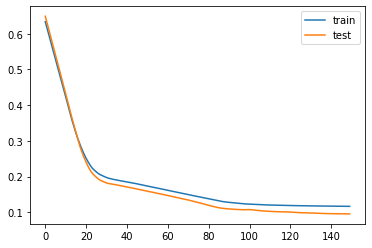

In [31]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [33]:
zeros = np.zeros(dataset.shape[0]-inv_yhat.shape[0]).astype(np.float32)
predictions = np.concatenate((zeros, inv_yhat), axis=None)
dataset['Predictions_open'] = predictions
dataset[['Predictions_open']] = dataset[['Predictions_open']].replace(0,np.NaN)

In [34]:
dataset = dataset.reset_index()

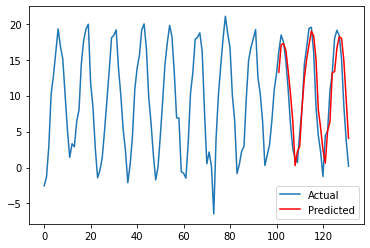

In [35]:
pyplot.plot(dataset[['Temperature']].values, label='Actual')
pyplot.plot(dataset[['Predictions_open']], label='Predicted', color='red')

pyplot.legend()
pyplot.show()

In [36]:
# calculate RMSE
rmspe_LSTM = calc_rmspe(inv_y, inv_yhat)
rsq_LSTM = r2_score(inv_y,inv_yhat)
print('Test RMSPE: %.3f' % rmspe_LSTM)
print('Test root square error: %.3f' % rsq_LSTM)

Test RMSE: 405.196
Test root square error: 0.776


## Polynomial regression

### Evaluation

In [28]:
print('ARIMA RMSE:\t %.3f' % rsmeARIMA)
print('ARIMA r2:\t %.3f' % rsqARIMA)
print()
print('LSTM RMSE:\t %.3f' % rmspe_LSTM)
print('LSTM r2:\t %.3f' % rsq_LSTM)

NameError: name 'rsmeARIMA' is not defined